In [10]:
import csv
import copy
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
from pandas.api.types import CategoricalDtype
from Bio import GenBank

from matplotlib import pyplot as plt

In [2]:
ngs_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Marker_Frequency_Analysis/Final_NGS_Mapping.pkl")
ngs_df_subset = ngs_df.iloc[np.random.randint(0,len(ngs_df),size=(100000,))]

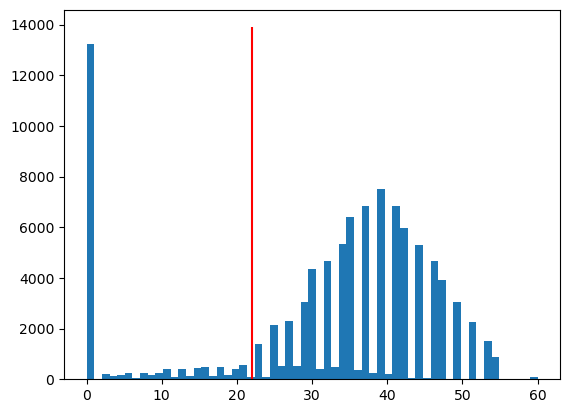

In [3]:
minimum_mapping_qual = 22

plt.hist(ngs_df_subset["MAPping Quality"].sample(n=100000),bins=59,range=(0,60))
y_min, y_max = plt.gca().get_ylim()
plt.vlines(minimum_mapping_qual,y_min, y_max,color="red")

In [4]:
ngs_df_filtered = ngs_df[ngs_df["MAPping Quality"]>minimum_mapping_qual]

In [5]:
name_to_strain = {old_cat:old_cat.split("_")[2].split("-")[0] for old_cat in ngs_df_filtered["Full Sample Name"].cat.categories}
name_to_condition = {old_cat:old_cat.split("_")[2].split("-")[1] for old_cat in ngs_df_filtered["Full Sample Name"].cat.categories}
name_to_replicate = {old_cat:old_cat.split("_")[2].split("-")[3] for old_cat in ngs_df_filtered["Full Sample Name"].cat.categories}

## replace chlor misnaming
succinate_name_to_condition = {}
for key, val in name_to_condition.items():
    if val == "Chlor":
        succinate_name_to_condition[key] = "Succinate"
    else:
        succinate_name_to_condition[key] = val

In [6]:
strain_cat = CategoricalDtype(set(name_to_strain.values()))
condition_cat = CategoricalDtype(set(succinate_name_to_condition.values()))
replicate_cat = CategoricalDtype(set(name_to_replicate.values()))

In [7]:
ngs_df_filtered["Strain"] = ngs_df_filtered["Full Sample Name"].apply(lambda x: name_to_strain[x]).astype(strain_cat)
ngs_df_filtered["Condition"] = ngs_df_filtered["Full Sample Name"].apply(lambda x: succinate_name_to_condition[x]).astype(condition_cat)
ngs_df_filtered["Replicate"] = ngs_df_filtered["Full Sample Name"].apply(lambda x: name_to_replicate[x]).astype(replicate_cat)

/tmp/ipykernel_11802/3090552793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngs_df_filtered["Strain"] = ngs_df_filtered["Full Sample Name"].apply(lambda x: name_to_strain[x]).astype(strain_cat)
/tmp/ipykernel_11802/3090552793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngs_df_filtered["Condition"] = ngs_df_filtered["Full Sample Name"].apply(lambda x: succinate_name_to_condition[x]).astype(condition_cat)
/tmp/ipykernel_11802/3090552793.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [8]:
ngs_df_filtered.to_pickle("./Final_NGS_Mapping_Filtered.pkl")

In [3]:
with open("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Marker_Frequency_Analysis/U00096_3.gb") as gb_handle:
    genome_ref = GenBank.read(gb_handle)
genome_size = int(genome_ref.size)
oriC_feature = [item for item in genome_ref.features if item.key=="rep_origin"][0]
oriC_position = int(np.mean([int(item) for item in oriC_feature.location.split("..")]))
circ_coord_fn = lambda x: np.where((x-oriC_position)<-genome_size//2,genome_size + (x-oriC_position),(x-oriC_position))

In [2]:
ngs_df_filtered = pd.read_pickle("./Final_NGS_Mapping_Filtered.pkl")
ngs_df_filtered["Circular Ref Position"]=circ_coord_fn(ngs_df_filtered["Ref Position"].astype("int32"))

/home/de64/micromamba/envs/nanopore/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1217: BiopythonParserWarning: Premature end of file in sequence data
  warnings.warn(


In [3]:
bin_size = 100000

ngs_df_filtered["Circular Ref Bin"] = pd.cut(ngs_df_filtered["Circular Ref Position"],list(range(-genome_size//2,genome_size//2,bin_size)))
ngs_df_filtered["Ref Bin"] = pd.cut(ngs_df_filtered["Ref Position"],list(range(0,genome_size,bin_size)))

In [4]:
circular_ref_pos_groupby = ngs_df_filtered.groupby(["Strain","Condition","Replicate","Circular Ref Bin"])["Circular Ref Position"]
count_per_category = circular_ref_pos_groupby.size().to_frame()
count_per_category = count_per_category.reset_index().set_index(["Strain","Condition","Replicate"]).rename(columns={"Circular Ref Position":"Circular Read Count"})
count_per_category = count_per_category.rename(columns = {"Circular Ref Bin":"Ref Bin", "Circular Read Count":"Read Count"})
count_per_category_noncirc = ngs_df_filtered.groupby(["Strain","Condition","Replicate","Ref Bin"])["Ref Position"].size().to_frame()
count_per_category_noncirc = count_per_category_noncirc.reset_index().set_index(["Strain","Condition","Replicate"]).rename(columns={"Ref Position":"Read Count"})
count_per_category["Circular Coords"] = True
count_per_category_noncirc["Circular Coords"] = False
count_output = pd.concat([count_per_category,count_per_category_noncirc],axis=0)
count_output = count_output.reset_index().set_index(["Circular Coords","Strain","Condition","Replicate"])
count_output.to_pickle("./Final_NGS_Marker_Frequencies.pkl")

/tmp/ipykernel_28958/1412146253.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  circular_ref_pos_groupby = ngs_df_filtered.groupby(["Strain","Condition","Replicate","Circular Ref Bin"])["Circular Ref Position"]
/tmp/ipykernel_28958/1412146253.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_per_category_noncirc = ngs_df_filtered.groupby(["Strain","Condition","Replicate","Ref Bin"])["Ref Position"].size().to_frame()


In [11]:
count_df = pd.read_pickle("./Final_NGS_Marker_Frequencies.pkl")
ttl_reads_per_sample = count_df.groupby(["Circular Coords","Strain","Condition","Replicate"])["Read Count"].sum().to_frame()
ttl_reads_per_sample = ttl_reads_per_sample.rename(columns={"Read Count":"Total Read Count"})
count_df = count_df.join(ttl_reads_per_sample)
count_df["Marker Freq"] = (count_df["Read Count"]/count_df["Total Read Count"])
count_df = count_df.dropna()

/tmp/ipykernel_21795/387193326.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ttl_reads_per_sample = count_df.groupby(["Circular Coords","Strain","Condition","Replicate"])["Read Count"].sum().to_frame()


In [12]:
agg_marker_frequency_df = count_df.reset_index().groupby(["Circular Coords","Strain","Condition","Ref Bin"])["Marker Freq"].mean().to_frame().rename(columns={"Marker Freq":"Mean Marker Frequency"})
agg_marker_frequency_df["StdErr Marker Frequency"] = count_df.reset_index().groupby(["Circular Coords","Strain","Condition","Ref Bin"])["Marker Freq"].sem()
agg_marker_frequency_df = agg_marker_frequency_df.dropna()
agg_marker_frequency_df = agg_marker_frequency_df.reset_index()
agg_marker_frequency_df["Ref Position"] = agg_marker_frequency_df["Ref Bin"].apply(lambda x: int(x.mid))
agg_marker_frequency_df = agg_marker_frequency_df.set_index(["Circular Coords","Strain","Condition","Ref Bin"])

/tmp/ipykernel_21795/463828385.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_marker_frequency_df = count_df.reset_index().groupby(["Circular Coords","Strain","Condition","Ref Bin"])["Marker Freq"].mean().to_frame().rename(columns={"Marker Freq":"Mean Marker Frequency"})
/tmp/ipykernel_21795/463828385.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_marker_frequency_df["StdErr Marker Frequency"] = count_df.reset_index().groupby(["Circular Coords","Strain","Condition","Ref Bin"])["Marker Freq"].sem()


In [13]:
succinate_control_df = agg_marker_frequency_df.reset_index().set_index(["Strain","Condition"]).loc["DE19","Succinate"].reset_index(drop=True)
succinate_control_df = succinate_control_df.rename(columns={"Mean Marker Frequency":"Control Mean","StdErr Marker Frequency":"Control StdErr"})
agg_marker_frequency_df = agg_marker_frequency_df.join(succinate_control_df.set_index(["Circular Coords","Ref Position"]),on=["Circular Coords","Ref Position"])
agg_marker_frequency_df["Mean Marker Frequency Control Ratio"] = agg_marker_frequency_df["Mean Marker Frequency"]/agg_marker_frequency_df["Control Mean"]
agg_marker_frequency_df["StdErr Marker Frequency Control Ratio"] = ((agg_marker_frequency_df["Mean Marker Frequency Control Ratio"]**2)*\
                                                                    ((agg_marker_frequency_df["StdErr Marker Frequency"]/\
                                                                     agg_marker_frequency_df["Mean Marker Frequency"])**2 +\
                                                                     (agg_marker_frequency_df["Control StdErr"]/\
                                                                     agg_marker_frequency_df["Control Mean"])**2))**(1/2)

agg_marker_frequency_df["Mean Log2 Control Ratio"] = np.log2(agg_marker_frequency_df["Mean Marker Frequency Control Ratio"])
agg_marker_frequency_df["StdErr Log2 Control Ratio"] = agg_marker_frequency_df["StdErr Marker Frequency Control Ratio"]/\
                                                    (agg_marker_frequency_df["Mean Marker Frequency Control Ratio"]*np.log(2))
agg_marker_frequency_df_circ = agg_marker_frequency_df.loc[True]
agg_marker_frequency_df_noncirc = agg_marker_frequency_df.loc[False]

agg_marker_frequency_df_circ.to_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Marker_Frequency_Analysis/Marker_Frequencies_100kb_CircularRef.csv")

/tmp/ipykernel_21795/3827255329.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  succinate_control_df = agg_marker_frequency_df.reset_index().set_index(["Strain","Condition"]).loc["DE19","Succinate"].reset_index(drop=True)
